# ICML 2020. Paper XXX 


Load package with the algorithms and ML models

In [1]:
] activate ../../Acceleration

 Activating environment at `~/Desktop/Code/Acceleration/Acceleration/Project.toml`


Select the dataset and ML models. The ML model returns the functions and constants required by the algorithms (i.e., objective evaluation, compute gradients, smoothness parameters, etc.)

In [33]:
using Acceleration
using LinearAlgebra

data, labels = load_libsvm_dataset("mushrooms",500); # dataset name (a5a, mushrooms), num samples
f,∇f,∇ϕ_cjg,σ,L,μ  = logistic_regression(data,labels,1);

┌ Info: Loading dataset mushrooms with 500 samples (out ouf 8124) and 112 features
└ @ Acceleration /Users/victor/Desktop/Code/Acceleration/Acceleration/src/libsvm_datasets.jl:25


## Experiement A. Convergence with exact gradients.
 The convergence rate of our algorithm is:

\begin{align}
\! \! f(y_k) - f^\star \le \frac{2ML}{\sigma } \prod_{i=1}^k \left(1 + \max \left\{ \frac{2}{i}, \sqrt \frac{\mu}{L} \right\} \right)^{-1}
\label{eq:accelerated_bound}
\end{align}
where $\sigma$, $M$, and $L$ are constants. Constants $\mu$ and $L$ depend on the strong convexity and smootheness of the objective function. This experiment shows the behavior of our algorithm (i.e., how it transitions from sublinear rate ($1/k^2$) to linear rate) and compares its performance to state-of-the-art algorithms.

### Simulation

In [63]:
d,n = size(data)
x_ini = zeros(n)
k = 2000;
μ = 1
L = 500
ω = 0; 

function exact_gradient(x)
    return ∇f(x), 0
end

grad_fun = exact_gradient

@time f_opt = ufom(f,exact_gradient,∇ϕ_cjg,x_ini,σ,L,μ,2*k,Inf,false)[end]

@time p1 = MD(f,grad_fun,∇ϕ_cjg,x_ini,σ,L,k) .- f_opt;
@time p2 = PGD_avg(f,grad_fun,∇ϕ_cjg,x_ini,σ,L,k) .- f_opt;
@time p3 = ufom(f,grad_fun,∇ϕ_cjg,x_ini,σ,L,μ,k,5,true) .- f_opt; # Our algorithm
@time p4 = AMD_plus(f,grad_fun,∇ϕ_cjg,x_ini,σ,L,k) .- f_opt;
@time p5 = μAMD_plus(f,grad_fun,∇ϕ_cjg,x_ini,L,μ,k) .- f_opt;
#@time p6 = ACGD(f,grad_fun,x_ini,L,k,ω) .- f_opt;
@time p7 = μACGD(f,grad_fun,x_ini,L,μ,k,ω) .- f_opt;
@time p8 = AGD(f,grad_fun,x_ini,k) .- f_opt;

  0.978775 seconds (352.55 k allocations: 5.217 GiB, 15.90% gc time)
  0.444907 seconds (91.22 k allocations: 2.592 GiB, 16.34% gc time)
  0.472697 seconds (90.03 k allocations: 2.592 GiB, 15.14% gc time)
  0.481868 seconds (239.54 k allocations: 2.612 GiB, 15.40% gc time)
  0.465540 seconds (111.98 k allocations: 2.599 GiB, 16.08% gc time)
  0.481583 seconds (134.64 k allocations: 2.608 GiB, 14.85% gc time)
  0.494575 seconds (127.26 k allocations: 2.603 GiB, 15.75% gc time)
  0.497933 seconds (165.31 k allocations: 2.598 GiB, 14.98% gc time)


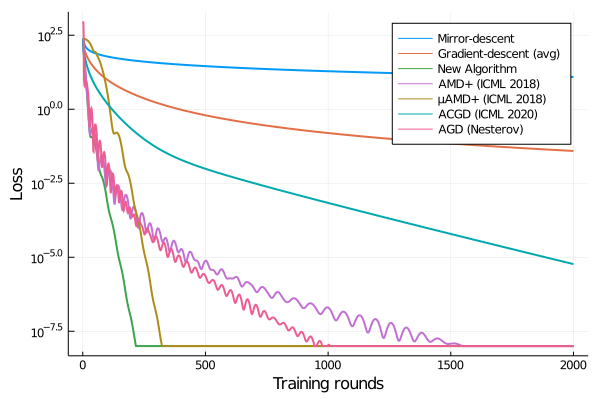

In [64]:
using Plots

fig = plot(max.(hcat(p1,p2,p3,p4,p5,p7,p8),1e-8),yaxis=:log, linewidth=2, legend=:topright,
label = ["Mirror-descent" "Gradient-descent (avg)" "New Algorithm" "AMD+ (ICML 2018)" "μAMD+ (ICML 2018)" "ACGD (ICML 2020)" "AGD (Nesterov)"], xlabel = "Training rounds", ylabel = "Loss")

## Experiment B
Convergence with gradient compression schemes. Recall that

\begin{align}
\widetilde \nabla f(x_k)  = \nabla f(x_k) + \xi_k
\end{align}
where $\xi_k \in \mathbf R^n$ and $\mathbb E[\xi_k] = 0$. In Federeated Learning, $\widetilde \nabla f(x_k)$ is the aggregate of all the clients' noisy graients.

### Gradient Compression Functions

In [36]:
function exact_gradient(x)
    return ∇f(x), 0
end

function noisy_gradient(x)
    n = size(x,1);
    ξ = 1; 
    noise = randn(n);
    noise = noise / norm(noise,2);
    noise = noise*ξ;
    return (∇f(x) + noise), ξ;
end

function binary(x)
    η = -∇f(x) + sign.(∇f(x)) .* (abs.(∇f(x)) .> norm(∇f(x),Inf)/2) .* norm(∇f(x),Inf)/2;
    return ∇f(x) + η, norm(η,2)
end

function random_sparsification(x)
    grad = ∇f(x)
    n = size(grad,1)
    r = 1/4;
    mask = Float64.(rand(n) .< r)
    rs_gradient = grad.*mask;
    return rs_gradient, norm(rs_gradient,2)
end

function dithering(x)
    q = Inf;
    grad = ∇f(x)
    n = size(grad,1)
    levels = 10;
    leveled_gradient = sign.(grad).*(levels/norm(grad,q)).*grad/2
    base = floor.(leveled_gradient)
    rv = Float64.(rand(n) .> (leveled_gradient .- floor.(leveled_gradient)))
    quantized_gradient = sign.(grad).*(base .+ rv)*norm(grad,q)/levels*2;
    
    return quantized_gradient, norm(quantized_gradient,2)
end

function natural_compression(x)

    grad = ∇f(x)
    n = size(grad,1)
    nat_grad = sign.(grad).*2.0.^(floor.(log2.(abs.(grad)))).*(1 .+ rand(n))
    
    return nat_grad, norm(nat_grad,2)
end

natural_compression (generic function with 1 method)

### Simulation

In [75]:
using LinearAlgebra

data, labels = load_libsvm_dataset("mushrooms",500); # dataset name (a5a, mushrooms), num samples
f,∇f,∇ϕ_cjg,σ,L,μ  = logistic_regression(data,labels,1);

k = 1000
n = size(data,2)
x_ini = zeros(n)
μ = 1
L = 1000

ω = 0;
@time f_opt = ufom(f,exact_gradient,∇ϕ_cjg,x_ini,σ,L,μ,10*k,Inf,false)[end]
grad_fun = exact_gradient
    
@time p1 = MD(f,grad_fun,∇ϕ_cjg,x_ini,σ,L,k) .- f_opt;
@time p2 = PGD_avg(f,grad_fun,∇ϕ_cjg,x_ini,σ,L,k) .- f_opt;
@time p3 = ufom(f,grad_fun,∇ϕ_cjg,x_ini,σ,L,μ,k,Inf,false) .- f_opt;
@time p4 = AMD_plus(f,grad_fun,∇ϕ_cjg,x_ini,σ,L,k) .- f_opt;
@time p5 = μAMD_plus(f,grad_fun,∇ϕ_cjg,x_ini,L,μ,k) .- f_opt;
#@time p6 = ACGD(f,grad_fun,x_ini,L,k,ω) .- f_opt;
@time p7 = μACGD(f,grad_fun,x_ini,L,μ,k,ω) .- f_opt;
@time p8 = AGD(f,grad_fun,x_ini,k) .- f_opt;

┌ Info: Loading dataset mushrooms with 500 samples (out ouf 8124) and 112 features
└ @ Acceleration /Users/victor/Desktop/Code/Acceleration/Acceleration/src/libsvm_datasets.jl:25


  2.184656 seconds (728.99 k allocations: 13.034 GiB, 16.74% gc time)
  0.219443 seconds (30.50 k allocations: 1.295 GiB, 15.70% gc time)
  0.218321 seconds (30.50 k allocations: 1.295 GiB, 17.00% gc time)
  0.212062 seconds (71.99 k allocations: 1.303 GiB, 16.22% gc time)
  0.217512 seconds (35.49 k allocations: 1.298 GiB, 15.18% gc time)
  0.215776 seconds (42.49 k allocations: 1.303 GiB, 16.66% gc time)
  0.227759 seconds (39.50 k allocations: 1.300 GiB, 16.57% gc time)
  0.231356 seconds (37.54 k allocations: 1.298 GiB, 16.99% gc time)


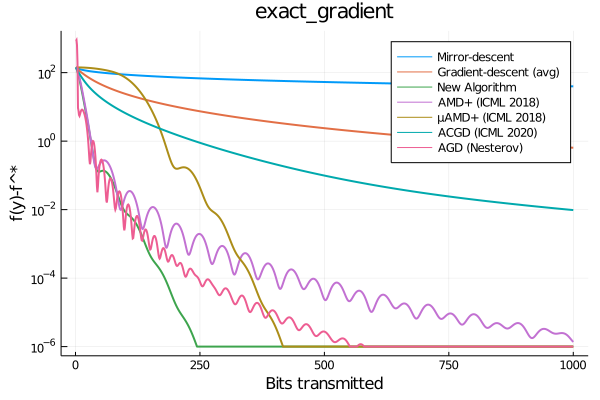

In [76]:
fig = plot(max.(min.(hcat(p1,p2,p3,p4,p5,p7,p8),1e3),1e-6),yaxis=:log, linewidth=2, legend=:topright,
label = ["Mirror-descent" "Gradient-descent (avg)" "New Algorithm" "AMD+ (ICML 2018)" "μAMD+ (ICML 2018)" "ACGD (ICML 2020)" "AGD (Nesterov)"], title=grad_fun, xlabel = "Bits transmitted", ylabel = "f(y)-f^*")

## Experiment C.

This experiment compares the proposed algorithm to:


Li, Z., Kovalev, D., Qian, X. &amp; Richtarik, P.. (2020). Acceleration for Compressed Gradient Descent in Distributed and Federated Optimization. <i>Proceedings of the 37th International Conference on Machine Learning</i>, in <i>Proceedings of Machine Learning Research</i> 119:5895-5904 Available from 
http://proceedings.mlr.press/v119/li20g.html

The simulation results are saved in text files. The plots can be generated using gnuplot with the following command:
```
gnuplot plots.gp
```
The script is in the "notes" folder, and the plots are the the folder "figures."


In [ ]:
using Acceleration
using LinearAlgebra

for model in ["mushrooms","a5a"]
    
    data, labels = load_libsvm_dataset(model,1000); # dataset name (a5a, mushrooms), num samples
    f,∇f,∇ϕ_cjg,σ,L,μ  = logistic_regression(data,labels,1);

    d,n = size(data)
    x_ini = zeros(n)
    k = 2000;
    μ = 0.1
    L = 200
    if(model=="a5a")
        L = 1000;
    end
    ω = 0;


    @time f_opt = ufom(f,exact_gradient,∇ϕ_cjg,x_ini,σ,L,μ,2*k,Inf,false)[end]

    @time for grad_fun in [exact_gradient,random_sparsification, dithering, natural_compression]

        p3 = max.(1e-12,ufom(f,grad_fun,∇ϕ_cjg,x_ini,σ,L,μ,k,Inf,false) .- f_opt);
        p4 = max.(1e-12,AMD_plus(f,grad_fun,∇ϕ_cjg,x_ini,σ,L,k) .- f_opt);
        p7 = max.(1e-12,μACGD(f,grad_fun,x_ini,L,μ,k,ω) .- f_opt);
    
        filename = string("logs/",model,"_",grad_fun,".txt")
        io = open(filename, "w")
        
        if(grad_fun==exact_gradient)
            bits = n*64;
        elseif(grad_fun==random_sparsification)
            bits = (n/4)*64;
        elseif(grad_fun==dithering)
            bits = 2.8*n + 64;
        elseif(grad_fun==natural_compression)
            bits = n*9;
        end
        
        for i=1:k
            print(io,i)
            print(io,"\t")
            print(io,i*n*64)
            print(io,"\t")
            print(io,i*bits)
            print(io,"\t")
            print(io, p7[i])
            print(io,"\t")
            print(io, p4[i])
            print(io,"\t")
            print(io, p3[i])
            print(io,"\n")
        end
        close(io)
    end
end

## Experiment D

In [ ]:
using LinearAlgebra

data, labels = load_dataset("MNIST",[0,1],1000,100);
f,∇f,∇ϕ_cjg,σ,L,μ  = linear_regression(data,labels);

k = 1000
n = size(data,2)
x_ini = zeros(n)

ω = 0;
@time f_opt = ufom(f,exact_gradient,∇ϕ_cjg,x_ini,σ,L,μ,10*k,Inf,false)[end]
grad_fun = exact_gradient
    
@time p1 = MD(f,grad_fun,∇ϕ_cjg,x_ini,σ,L,k) .- f_opt;
@time p2 = PGD_avg(f,grad_fun,∇ϕ_cjg,x_ini,σ,L,k) .- f_opt;
@time p3 = ufom(f,grad_fun,∇ϕ_cjg,x_ini,σ,L,μ,k,Inf,false) .- f_opt;
@time p4 = AMD_plus(f,grad_fun,∇ϕ_cjg,x_ini,σ,L,k) .- f_opt;
@time p5 = μAMD_plus(f,grad_fun,∇ϕ_cjg,x_ini,L,μ,k) .- f_opt;
@time p6 = ACGD(f,grad_fun,x_ini,L,k,ω) .- f_opt;
@time p7 = μACGD(f,grad_fun,x_ini,L,μ,k,ω) .- f_opt;


@time for grad_fun in [exact_gradient,noisy_gradient]

    @time p1 = max.(1e-12,MD(f,grad_fun,∇ϕ_cjg,x_ini,σ,L,k) .- f_opt);
    @time p2 = max.(PGD_avg(f,grad_fun,∇ϕ_cjg,x_ini,σ,L,k) .- f_opt);
    @time p3 = max.(ufom(f,grad_fun,∇ϕ_cjg,x_ini,σ,L,μ,k,Inf,true) .- f_opt);
    @time p4 = max.(AMD_plus(f,grad_fun,∇ϕ_cjg,x_ini,σ,L,k) .- f_opt);
    @time p5 = max.(μAMD_plus(f,grad_fun,∇ϕ_cjg,x_ini,L,μ,k) .- f_opt);
    @time p6 = max.(ACGD(f,grad_fun,x_ini,L,k,ω) .- f_opt);
    @time p7 = max.(μACGD(f,grad_fun,x_ini,L,μ,k,ω) .- f_opt);

    filename = string("logs/MNIST_",grad_fun,".txt")
    io = open(filename, "w")

    for i=1:k
        print(io,i)
        print(io,"\t")
        print(io, p1[i])
        print(io,"\t")
        print(io, p2[i])
        print(io,"\t")
        print(io, p3[i])
        print(io,"\t")
        print(io, p4[i])
        print(io,"\t")
        print(io, p5[i])
        print(io,"\t")
        print(io, p6[i])
        print(io,"\t")
        print(io, p7[i])
        print(io,"\n")
    end
    close(io)
end

In [ ]:
fig = plot(max.(min.(hcat(p1,p2,p3,p4,p5,p6,p7),1e3),1e-6),yaxis=:log, linewidth=2, legend=:topright,
label = ["Mirror-descent" "Gradient-descent (avg)" "New Algorithm" "AMD+ (ICML 2018)" "μAMD+ (ICML 2018)" "ACGD (ICML 2020)" "μACGD (ICML 2020)"], xlabel = "k", ylabel = "f(y_k)-f^*")